In [8]:
# Read in data
import pickle

with open("results_order_7_3e-6.pkl", "rb") as f:
    loaded_data = pickle.load(f)

# Access like this:
best_params = loaded_data["best_params_list"]
final_loss = loaded_data["final_loss_list"]
loss_history = loaded_data["loss_history_list"]
mismatch_mean = loaded_data["mismatch_mean_list"]
mismatch_std = loaded_data["mismatch_std_list"]

In [4]:
with open("results_crop_40_order_7_3e-6.pkl", "rb") as f:
    loaded_data_crop = pickle.load(f)

# Access like this:
best_params_crop = loaded_data_crop["best_params_list"]
final_loss_crop = loaded_data_crop["final_loss_list"]
loss_history_crop = loaded_data_crop["loss_history_list"]
mismatch_mean_crop = loaded_data_crop["mismatch_mean_list"]
mismatch_std_crop = loaded_data_crop["mismatch_std_list"]

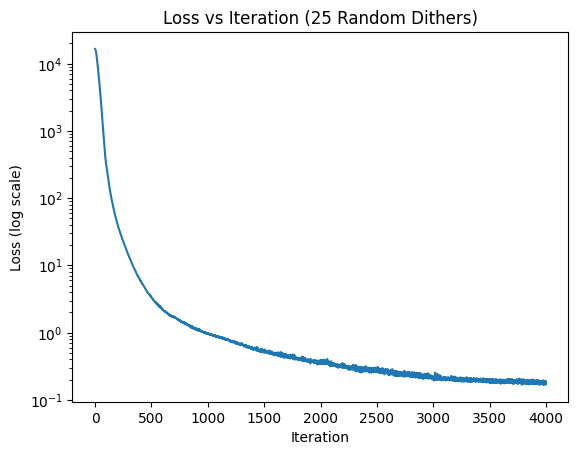

In [6]:
import matplotlib.pyplot as plt
plt.figure()
plt.semilogy(loss_history_crop[12])
plt.xlabel("Iteration")
plt.ylabel("Loss (log scale)")
plt.title("Loss vs Iteration (25 Random Dithers)")
#lt.savefig("25_dither_loss_order_7.png")
plt.show()


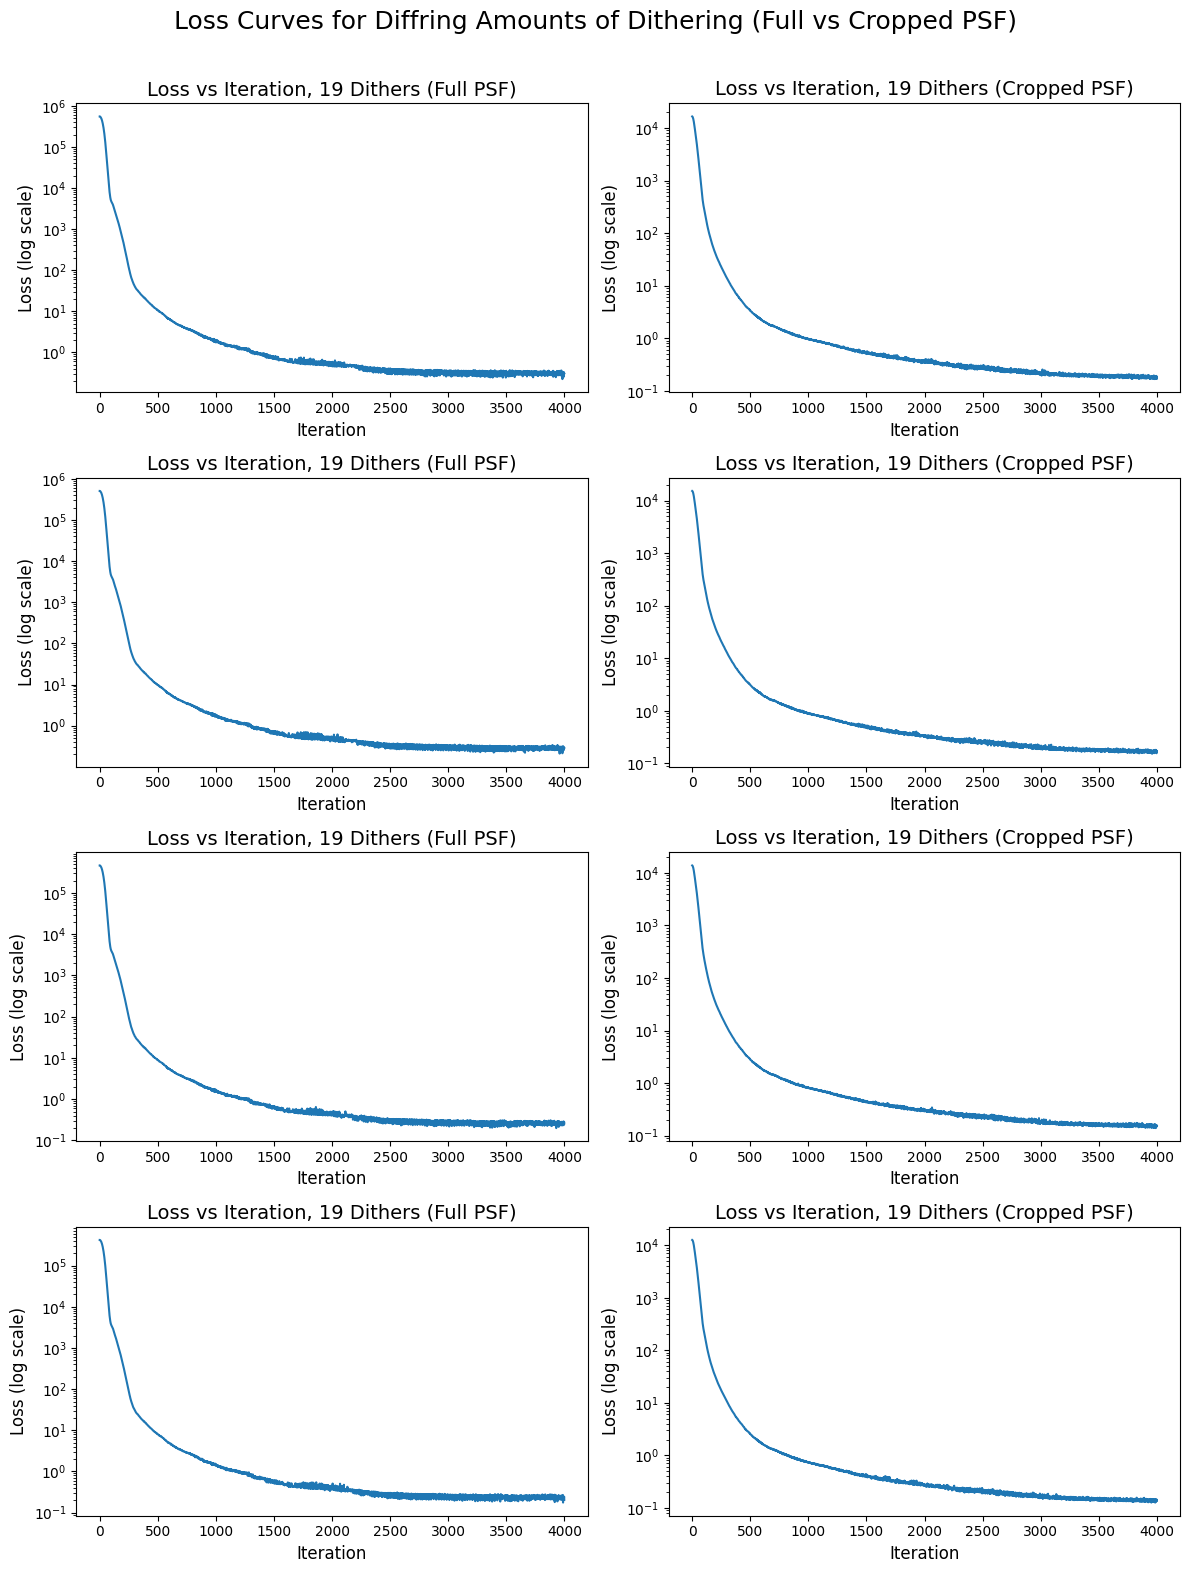

In [ ]:
import matplotlib.pyplot as plt

# Font size options (customize these)
title_fontsize = 14
axis_fontsize = 12
overall_title_fontsize = 18

# Create figure and axes for 4x2 grid (8 subplots)
fig, axs = plt.subplots(4, 2, figsize=(12, 16))

# Indices to plot: -12, -11, -10, -9
indices = [12, 11, 10, 9]

for i, idx in enumerate(indices):
    # Left column: loss_history
    ax_left = axs[i, 0]
    ax_left.semilogy(loss_history[idx])
    if i == 12:
        ax_left.set_title(f"Loss vs Iteration, 25 Dithers (Full PSF)", fontsize=title_fontsize)
    elif i == 11:
        ax_left.set_title(f"Loss vs Iteration, 23 Dithers (Full PSF)", fontsize=title_fontsize)
    elif i == 10:
        ax_left.set_title(f"Loss vs Iteration, 21 Dithers (Full PSF)", fontsize=title_fontsize)
    else:
        ax_left.set_title(f"Loss vs Iteration, 19 Dithers (Full PSF)", fontsize=title_fontsize)
    ax_left.set_xlabel("Iteration", fontsize=axis_fontsize)
    ax_left.set_ylabel("Loss (log scale)", fontsize=axis_fontsize)
    ax_left.tick_params(labelsize=10)
    
    # Right column: loss_history_crop
    ax_right = axs[i, 1]
    ax_right.semilogy(loss_history_crop[idx])
    if i == 12:
        ax_right.set_title(f"Loss vs Iteration, 25 Dithers (Cropped PSF)", fontsize=title_fontsize)
    elif i == 11:
        ax_right.set_title(f"Loss vs Iteration, 23 Dithers (Cropped PSF)", fontsize=title_fontsize)
    elif i == 10:
        ax_right.set_title(f"Loss vs Iteration, 21 Dithers (Cropped PSF)", fontsize=title_fontsize)
    else:
        ax_right.set_title(f"Loss vs Iteration, 19 Dithers (Cropped PSF)", fontsize=title_fontsize)
    ax_right.set_xlabel("Iteration", fontsize=axis_fontsize)
    ax_right.set_ylabel("Loss (log scale)", fontsize=axis_fontsize)
    ax_right.tick_params(labelsize=10)

# Add overall title
fig.suptitle("Loss Curves for Diffring Amounts of Dithering (Full vs Cropped PSF)", fontsize=overall_title_fontsize)

# Adjust layout to fit everything nicely
plt.tight_layout(rect=[0, 0, 1, 0.97])
#plt.savefig("full_vs_cropped_psf_loss_curves.png")
plt.show()



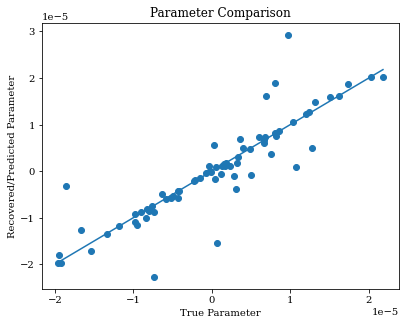

In [14]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax.scipy.ndimage import map_coordinates
import jax.lax as lax
import optax
from tqdm.auto import trange, tqdm

n_terms = 36
true_params = 1e-5 * jax.random.normal(jax.random.PRNGKey(0), shape=(2*n_terms,))
# Convert to NumPy arrays if they're JAX arrays
true_vals = np.array(true_params)
pred_vals = np.array(best_params[0])

plt.figure()
plt.scatter(true_vals, pred_vals)

# Add a diagonal line for reference
xmin, xmax = true_vals.min(), true_vals.max()
ref_line = np.array([xmin, xmax])
plt.plot(ref_line, ref_line)

plt.xlabel("True Parameter")
plt.ylabel("Recovered/Predicted Parameter")
plt.title("Parameter Comparison")
plt.savefig("predicted_vs_true_order_7.png")

plt.show()

In [24]:
print("Index |        True Param        |     Predicted Param")
print("------|--------------------------|----------------------")
for i in range(len(true_params)):
    if abs(true_params[i] - best_params[0][i]) > 0.5e-5:
        print(f"{i:4d}  |  {float(true_params[i]):+12.6e}  |  {float(best_params[0][i]):+12.6e}")


Index |        True Param        |     Predicted Param
------|--------------------------|----------------------
   7  |  +4.943786e-06  |  -8.231255e-07
  14  |  +1.277085e-05  |  +4.944797e-06
  16  |  +9.706559e-06  |  +2.927013e-05
  18  |  +2.470071e-07  |  +5.695642e-06
  20  |  -1.859349e-05  |  -3.133245e-06
  27  |  +6.902801e-06  |  +1.615786e-05
  29  |  -7.409900e-06  |  -2.265795e-05
  31  |  +3.026918e-06  |  -3.744556e-06
  35  |  +7.052256e-07  |  -1.535079e-05
  55  |  +8.038295e-06  |  +1.885541e-05
  70  |  +1.068016e-05  |  +9.545612e-07


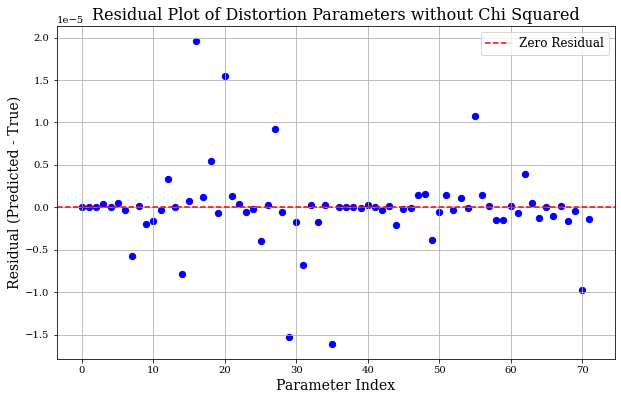

In [13]:
# Convert JAX arrays to NumPy arrays (if needed)
true_vals = np.array(true_params)          # True parameter values
pred_vals = np.array(best_params[0])  # Use the best parameters from your last (or chosen) dither case

# Compute the residuals (difference between predicted and true parameters)
residuals = pred_vals - true_vals

# Option 1: Plot residuals against parameter index
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(true_vals)), residuals, color='blue', s=40)
plt.axhline(0, color='red', linestyle='--', label="Zero Residual")
plt.xlabel("Parameter Index", fontsize=14)
plt.ylabel("Residual (Predicted - True)", fontsize=14)
plt.title("Residual Plot of Distortion Parameters without Chi Squared", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.savefig("residual_vs_param_index_order_7_1e-5.png")
plt.show()

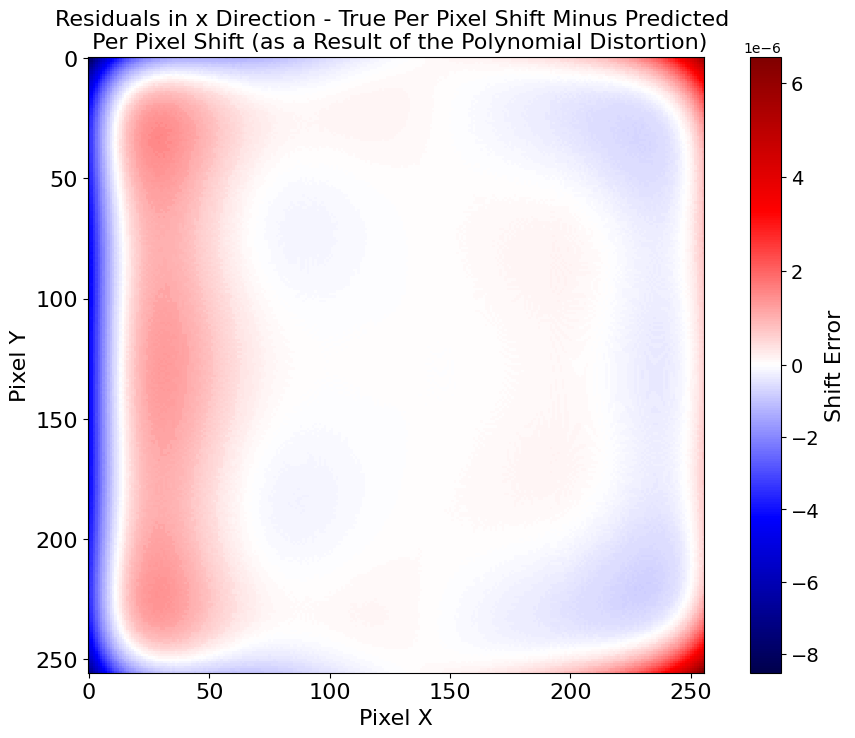

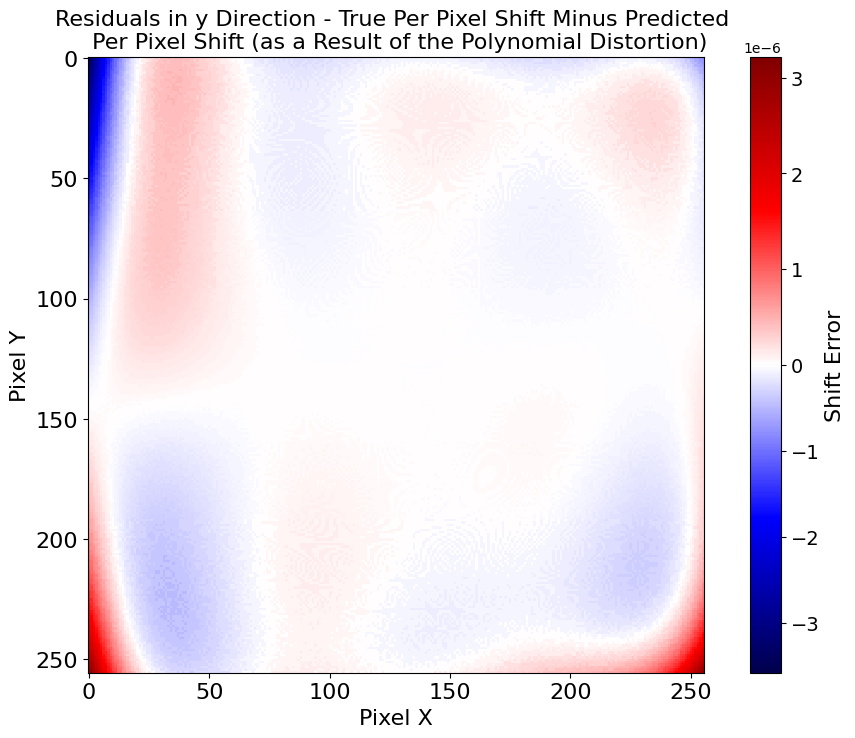

0.00071365596
-0.00039077038


In [24]:
N = 256
pixel_scale = 0.375
def create_image_coords(npix, pixel_scale):
    """
    Returns two arrays (grid_x, grid_y) each of shape (npix, npix),
    spanning [-1,1]. (pixel_scale is ignored to keep the coordinate domain small.)
    """
    coords_1d = jnp.linspace(-1.0, 1.0, npix)
    grid_x, grid_y = jnp.meshgrid(coords_1d, coords_1d, indexing="xy")
    return grid_x, grid_y
def distort_coords(params, coords, powers):
    """
    params: shape (2*N,) where N = number of polynomial terms
      The first N are x-distortion coeffs, the last N are y-distortion coeffs.
    coords: shape (2, npix, npix) -> coords[0] = x-grid, coords[1] = y-grid
    powers: list of (p,q) exponent pairs
    Returns (x_dist, y_dist), same shape as coords
    """
    x_grid, y_grid = coords

    # Number of polynomial terms
    n_terms = len(powers)
    # Split params into x-coeffs, y-coeffs
    px = params[:n_terms]
    py = params[n_terms:]

    # Evaluate x-distortion
    shift_x = jnp.zeros_like(x_grid)
    shift_y = jnp.zeros_like(y_grid)

    for i, (p, q) in enumerate(powers):
        shift_x += px[i] * (x_grid**p) * (y_grid**q)
        shift_y += py[i] * (x_grid**p) * (y_grid**q)

    # Return new coords
    x_dist = x_grid + shift_x
    y_dist = y_grid + shift_y

    return x_dist, y_dist

def get_polynomial_powers(order):
    """
    Returns a list of (p, q) for all terms x^p * y^q with p+q <= order.
    For order=7, you'll get 36 pairs.
    """
    powers = []
    for n in range(order+1):
        for p in range(n+1):
            q = n - p
            powers.append((p, q))
    return powers

order = 7
powers = get_polynomial_powers(order)
# Calculate the ideal coordinate grid.
coords = create_image_coords(N, pixel_scale)  # returns (x_grid, y_grid)

# Compute the distorted coordinates using the true polynomial coefficients.
true_params = 1e-5 * jax.random.normal(jax.random.PRNGKey(0), shape=(2*n_terms,))
true_distorted_coords = distort_coords(true_params, coords, powers)
# And compute the per-pixel true shifts (difference from the ideal grid).
true_x_shift = true_distorted_coords[0] - coords[0]
true_y_shift = true_distorted_coords[1] - coords[1]

# Compute the distorted coordinates using the recovered polynomial coefficients.
recovered_distorted_coords = distort_coords(best_params[12], coords, powers)
# And compute the per-pixel predicted shifts.
pred_x_shift = recovered_distorted_coords[0] - coords[0]
pred_y_shift = recovered_distorted_coords[1] - coords[1]

# Compute the difference between the true and predicted shift fields.
diff_x = true_x_shift - pred_x_shift
diff_y = true_y_shift - pred_y_shift

import matplotlib.colors as colors
vmin_x = diff_x.min()
vmax_x = diff_x.max()
norm_x = colors.TwoSlopeNorm(vmin=vmin_x, vcenter=0, vmax=vmax_x)

vmin_y = diff_y.min()
vmax_y = diff_y.max()
norm_y = colors.TwoSlopeNorm(vmin=vmin_y, vcenter=0, vmax=vmax_y)

plt.figure(figsize=(12, 8)) 
im = plt.imshow(diff_x, cmap="seismic", norm=norm_x, interpolation="nearest")
plt.title("Residuals in x Direction - True Per Pixel Shift Minus Predicted \n Per Pixel Shift (as a Result of the Polynomial Distortion)", fontsize=16)
plt.xlabel("Pixel X", fontsize=16)
plt.ylabel("Pixel Y", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
cbar = plt.colorbar(im)
cbar.ax.set_ylabel("Shift Error", fontsize=16)
cbar.ax.tick_params(labelsize=14)
plt.show()

plt.figure(figsize=(12, 8)) 
im = plt.imshow(diff_y, cmap="seismic", norm=norm_y, interpolation="nearest")
plt.title("Residuals in y Direction - True Per Pixel Shift Minus Predicted \n Per Pixel Shift (as a Result of the Polynomial Distortion)", fontsize=16)
plt.xlabel("Pixel X", fontsize=16)
plt.ylabel("Pixel Y", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
cbar = plt.colorbar(im)
cbar.ax.set_ylabel("Shift Error", fontsize=16)
cbar.ax.tick_params(labelsize=14)
plt.show()

x_loss = np.sum(diff_x)
y_loss = np.sum(diff_y)
print(x_loss)
print(y_loss)

In [2]:
import matplotlib.pyplot as plt

import dLux as dl
import dLux.utils as dlu
import dLuxToliman as dlT
import math

# Core jax
import jax
# from jax.config import config
# from jax import Array, vmap

import jax.numpy as jnp
import jax.random as jr
import numpy as np
import equinox as eqx
# Optimisation
import zodiax as zdx
import optax

# Optics
import dLux as dl
import dLux.utils as dlu

# Plotting/visualisation
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["text.usetex"] = 'false'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72
# This was made using Connor's help - I think it's mostly a direct copy of code he already has in his repo.
phase_mask = np.load("/Users/angusrutherford/Desktop/dLuxToliman/new_diffractive_pupil.npy")

mask = dl.Optic(phase=phase_mask)

wavefront_npix = 2000 # 2000 # Wavefront number of pixels
aperture_diam = 0.125 # Diameter of aperture (m)
oversample = 1
coords = dlu.pixel_coords(wavefront_npix * oversample, aperture_diam)
secondary_diam = 0.032 # Diameter of secondary mirror (m)
spider_width = 0.002 # Spider width (m)
psf_npixels = 256 #3600 # Number of pixels across one axis on detector
pixel_scale = 0.375 # Converting angle between binary source to angle on detector
primary = dlu.circle(coords, aperture_diam/2)
secondary = dlu.circle(coords, secondary_diam/2, invert=True)
angles = [0, 120, 240]
spiders = dlu.spider(coords, spider_width, angles)

aperture = dlu.combine([primary, secondary, spiders], oversample)

# Define the optical layers
layers = [("aperture", dl.layers.Optic(aperture, normalise=True)), ("phase_mask", mask)]

# Construct the optics object
# optics = dl.AngularOpticalSystem(wavefront_npix, aperture_diam, layers, psf_npixels, pixel_scale, oversample)
optics = dlT.TolimanOpticalSystem(
    wavefront_npix,
    psf_npixels,
    oversample,
    pixel_scale,
    mask=mask,
    radial_orders=[6]
    )
# Build a source
source = dlT.AlphaCen(
    n_wavels=3,
    separation=10.0,
    position_angle=90,
    x_position=0,
    y_position=0,
    log_flux=6.832,
    contrast=3.37,
    bandpass=(530, 640),
    weights=None
)

instrument = dlT.Toliman(optics, source)

psf = instrument.model()

In [3]:
import jax
import jax.numpy as jnp
from jax import vmap
from jax.scipy.ndimage import map_coordinates
from jaxopt import LevenbergMarquardt  # LM solver from JaxOpt
import optax  # (Optional)
from tqdm.auto import trange, tqdm
import numpy as np

###############################################################################
# 0) Dither offsets function (only along x) 
###############################################################################
def get_dither_offsets_random_only_x(k, scale, r_factor=1.0, key=None):
    """
    Returns exactly k dither offsets (jnp.array of shape (k, 2)), where k is an odd integer.
    One offset is [0, 0], and the remaining (k-1) offsets are randomly placed along the x-axis,
    uniformly in the range [-scale*r_factor, scale*r_factor], with y fixed at 0.
    """
    if k % 2 == 0:
        raise ValueError("k must be an odd number.")
    if key is None:
        key = jax.random.PRNGKey(0)
    if k == 1:
        return scale * jnp.array([[0, 0]])
    
    # Only dither in x-direction; y is always 0
    x_offsets = jax.random.uniform(key, shape=(k - 1, 1), minval=-scale * r_factor, maxval=scale * r_factor)
    y_offsets = jnp.zeros_like(x_offsets)
    random_offsets = jnp.concatenate([x_offsets, y_offsets], axis=1)

    # Include the central offset [0, 0]
    offsets = jnp.concatenate([jnp.zeros((1, 2)), random_offsets], axis=0)
    return offsets

###############################################################################
# 1) Create normalized coordinate grid [-1, +1] & build polynomial powers
###############################################################################
def create_image_coords(npix, pixel_scale):
    """
    Returns two arrays (grid_x, grid_y) each of shape (npix, npix),
    spanning [-1,1]. (pixel_scale is ignored here to keep domain small.)
    """
    coords_1d = jnp.linspace(-1.0, 1.0, npix)
    grid_x, grid_y = jnp.meshgrid(coords_1d, coords_1d, indexing="xy")
    return grid_x, grid_y

def get_polynomial_powers(order):
    """
    Returns a list of (p, q) pairs for all terms x^p * y^q with p+q <= order.
    For order=7, that yields 36 terms.
    """
    powers = []
    for n in range(order + 1):
        for p in range(n + 1):
            q = n - p
            powers.append((p, q))
    return powers

###############################################################################
# 2) Distortion function: warp coordinates via polynomial expansions
###############################################################################
def distort_coords(params, coords, powers):
    """
    Applies a polynomial distortion to the given coordinates.
    
    params: array of shape (2*N,), where the first N elements are the x-distortion
            coefficients and the last N are the y-distortion coefficients.
    coords: tuple (x_grid, y_grid), each shape (npix, npix) in [-1, 1].
    powers: list of (p, q) exponent pairs.
    
    Returns:
      (x_dist, y_dist) = distorted coordinates (each shape (npix, npix)).
    """
    x_grid, y_grid = coords
    n_terms = len(powers)
    px = params[:n_terms]
    py = params[n_terms:]
    
    shift_x = jnp.zeros_like(x_grid)
    shift_y = jnp.zeros_like(y_grid)
    
    # Evaluate the polynomial distortion at each pixel
    for i, (p, q) in enumerate(powers):
        shift_x += px[i] * (x_grid ** p) * (y_grid ** q)
        shift_y += py[i] * (x_grid ** p) * (y_grid ** q)
    
    return x_grid + shift_x, y_grid + shift_y

###############################################################################
# NEW: Oversample a given image using a 3x3 subpixel grid, then downsample by averaging
###############################################################################
def oversample_image(image, base_coords, oversample_factor=3):
    """
    Given an image and base coordinates (shape: (2, H, W)), this function creates a subpixel
    grid (of size oversample_factor x oversample_factor) for each pixel, samples the image at
    those subpixel locations, and then averages the values to produce a downsampled image of
    shape (H, W).
    """
    # base_coords: 2 x H x W
    H, W = base_coords.shape[1], base_coords.shape[2]
    # Create oversampling offsets: we assume each pixel spans 1 unit.
    offsets = jnp.linspace(-0.5, 0.5, oversample_factor)
    dR, dC = jnp.meshgrid(offsets, offsets, indexing="xy")
    dR = dR.ravel()  # shape (oversample_factor^2,)
    dC = dC.ravel()
    
    # Flatten base coordinate grids
    base_rows = base_coords[0].ravel()  # shape (H*W,)
    base_cols = base_coords[1].ravel()  # shape (H*W,)
    
    # For each pixel, add each subpixel offset
    oversampled_rows = base_rows[:, None] + dR[None, :]  # shape (H*W, oversample_factor^2)
    oversampled_cols = base_cols[:, None] + dC[None, :]    # shape (H*W, oversample_factor^2)
    
    # Flatten the oversampled coordinates to sample them all at once
    oversampled_rows_flat = oversampled_rows.ravel()
    oversampled_cols_flat = oversampled_cols.ravel()
    
    # Use map_coordinates to sample the image at these oversampled coordinates.
    sampled_vals = map_coordinates(image,
                                   jnp.stack([oversampled_rows_flat, oversampled_cols_flat], axis=0),
                                   order=1, mode="nearest")
    
    # Reshape sampled_vals to (H*W, oversample_factor^2) and average along the second axis.
    sampled_vals = sampled_vals.reshape(H * W, oversample_factor**2)
    mean_vals = jnp.mean(sampled_vals, axis=1)
    
    # Reshape the final result back to (H, W)
    return mean_vals.reshape(H, W)

###############################################################################
# 3) Sample an image at the distorted coordinates -> final "warped" image,
#     now with 3x3 oversampling then downsampling.
###############################################################################
def sample_image_at_distorted_coords(image, params, coords, powers):
    """
    Given an image, applies the polynomial distortion to its coordinate grid,
    oversamples using a 3x3 subpixel grid, and downsamples by averaging,
    resulting in the final warped image.
    
    The input grid (in [-1, 1]) is mapped into pixel indices [0, npix-1].
    """
    x_dist, y_dist = distort_coords(params, coords, powers)
    npix = image.shape[0]
    half = (npix - 1) / 2.0

    # Compute base pixel coordinates
    row_indices = half * (y_dist + 1.0)
    col_indices = half * (x_dist + 1.0)
    base_coords = jnp.stack([row_indices, col_indices], axis=0)  # shape (2, npix, npix)

    # Oversample with a 3x3 grid and then average
    return oversample_image(image, base_coords, oversample_factor=3)

###############################################################################
# 4) Build a residual function for Levenberg–Marquardt
###############################################################################
def create_residuals(params, ideal_images, distorted_images, coords, powers, lam=0.0):
    """
    Returns a 1D array of pixelwise residuals: (model - data).
    If lam > 0, we also include a "virtual residual" for L2 regularization.
    
    shape(ideal_images) = (B, npix, npix)
    shape(distorted_images) = (B, npix, npix)
    """
    # predicted shape = (B, npix, npix)
    predicted = vmap(
        lambda img: sample_image_at_distorted_coords(img, params, coords, powers)
    )(ideal_images)

    # Pixelwise residual
    base_residuals = (predicted - distorted_images).ravel()

    # If you want L2 regularization, treat it as extra residual(s):
    if lam > 0:
        reg_residuals = jnp.sqrt(lam) * params
        return jnp.concatenate([base_residuals, reg_residuals])
    
    return base_residuals

###############################################################################
# 5) LM-based fit function (uses jaxopt LevenbergMarquardt)
###############################################################################
def fit_polynomial_lm_jaxopt(
    ideal_images,
    distorted_images,
    coords,
    powers,
    lam=0.0,
    true_params=None
):
    """
    Recovers polynomial distortion parameters by minimizing SSE (via LM)
    over (ideal_images, distorted_images).

    If 'true_params' is provided, we compute the mismatch (sum of abs diffs)
    for the final param vector.

    Returns:
      best_params:  (array) the final best-fit param vector
      final_sse:    (float) sum of squares of final residual
      mismatch_mean (float) sum of abs differences vs. true_params
      mismatch_std  (float) zero in this single-run scenario
    """
    n_terms = len(powers)
    param_size = 2 * n_terms
    init_params = jnp.zeros(param_size)

    def residual_fun(params):
        return create_residuals(params, ideal_images, distorted_images, coords, powers, lam)

    solver = LevenbergMarquardt(residual_fun=residual_fun)
    sol = solver.run(init_params)

    best_params = sol.params
    final_residuals = residual_fun(best_params)
    final_sse = float(jnp.sum(final_residuals**2))

    mismatch_mean = mismatch_std = None
    if true_params is not None:
        diff = jnp.abs(best_params - true_params)
        mismatch_mean = float(jnp.sum(diff))
        mismatch_std = 0.0

    return best_params, final_sse, mismatch_mean, mismatch_std

###############################################################################
# 6) Compute parameter loss (for analysis only)
###############################################################################
def compute_parameter_loss(true_params, predicted_params):
    squared_loss = jnp.sum((true_params - predicted_params)**2)
    absolute_loss = jnp.sum(jnp.abs(true_params - predicted_params))
    return squared_loss, absolute_loss

###############################################################################
# 7) Main code: Loop over multiple dithers and perform LM fitting for each case
###############################################################################
# Set up coordinate grid and polynomial model
npix = 256
pixel_scale = 0.375
coords = create_image_coords(npix, pixel_scale)
order = 7
powers = get_polynomial_powers(order)
n_terms = len(powers)

# Convert pixel scale from arcsec to radians for dithering.
det_pixsize = dlu.arcsec2rad(pixel_scale)

# Some "true_params" for x-distortion + y-distortion
key = jax.random.PRNGKey(0)
true_params = 1e-5 * jax.random.normal(key, shape=(2*n_terms,))

# Storage lists for results
best_params_list = []
final_loss_list = []
mismatch_mean_list = []
mismatch_std_list = []
parameter_squared_loss_list = []
parameter_absolute_loss_list = []

# Use a fixed key for dither generation (or modify as needed)
dither_key = jax.random.PRNGKey(713)

# Loop over desired dither counts (odd numbers from 1 to 11 in this example)
for k in tqdm(range(1, 4, 2), desc="Outer Loop (Dither Count)", position=0):
    # Get dither offsets only in x
    dither_offsets = get_dither_offsets_random_only_x(k, det_pixsize, r_factor=jnp.sqrt(3), key=dither_key)
    
    psfs = []
    # Generate a PSF for each dither offset using your instrument
    for offset in dither_offsets:
        source = dlT.AlphaCen(
            n_wavels=3,
            separation=10.0,
            position_angle=90,
            x_position=float(offset[0]),
            y_position=float(offset[1]),
            log_flux=6.832,
            contrast=3.37,
            bandpass=(530, 640),
            weights=None
        )
        instrument = dlT.Toliman(optics, source)
        psf_dither = instrument.model()
        psfs.append(psf_dither)
    
    print(f"Number of PSFs for dither count {k}: {len(psfs)}")
    
    # Generate distorted PSFs from the ideal PSFs using the "true" polynomial
    distorted_psfs = [sample_image_at_distorted_coords(psf_item, true_params, coords, powers) 
                        for psf_item in psfs]
    
    # Stack into a batch (shape: (B, npix, npix))
    ideal_images = jnp.stack(psfs)
    distorted_images = jnp.stack(distorted_psfs)
    
    # Fit the polynomial distortion using LM with regularization
    lam_reg = 10  # Try adjusting this value as needed
    params, final_sse, mismatch_mean, mismatch_std = fit_polynomial_lm_jaxopt(
        ideal_images,
        distorted_images,
        coords,
        powers,
        lam=lam_reg,
        true_params=true_params
    )
    
    # Store results
    best_params_list.append(params)
    final_loss_list.append(final_sse)
    mismatch_mean_list.append(mismatch_mean)
    mismatch_std_list.append(mismatch_std)
    sq_loss, abs_loss = compute_parameter_loss(true_params, params)
    parameter_squared_loss_list.append(sq_loss)
    parameter_absolute_loss_list.append(abs_loss)

# Print summary results for each dither count
print("\nFinal fitting results for each dither count:")
for idx, k in enumerate(range(1, 4, 2)):
    print(f"Dither count {k}: Final SSE = {final_loss_list[idx]:.4e}, "
          f"Param Mismatch = {mismatch_mean_list[idx]:.4e}")



Outer Loop (Dither Count):   0%|          | 0/2 [00:00<?, ?it/s]

Number of PSFs for dither count 1: 1
Number of PSFs for dither count 3: 3

Final fitting results for each dither count:
Dither count 1: Final SSE = 1.0927e-03, Param Mismatch = 7.3010e-05
Dither count 3: Final SSE = 1.2858e-03, Param Mismatch = 1.6007e-05


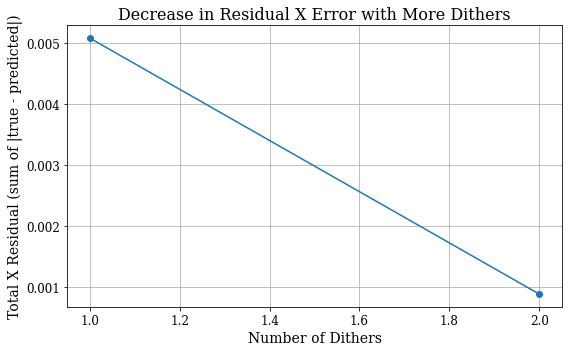

In [5]:
#Number of PSFs for dither count 1: 1
# Number of PSFs for dither count 3: 3
# Number of PSFs for dither count 5: 5
# Number of PSFs for dither count 7: 7
# Number of PSFs for dither count 9: 9
# Number of PSFs for dither count 11: 11

# Final fitting results for each dither count:
# Dither count 1: Final SSE = 3.4511e-04, Param Mismatch = 1.8970e-05
# Dither count 3: Final SSE = 2.2468e-03, Param Mismatch = 2.0457e-05
# Dither count 5: Final SSE = 2.5875e-03, Param Mismatch = 1.4872e-05
# Dither count 7: Final SSE = 1.4571e-02, Param Mismatch = 3.8058e-05
# Dither count 9: Final SSE = 1.2915e-02, Param Mismatch = 3.7777e-05
# Dither count 11: Final SSE = 5.5993e-03, Param Mismatch = 2.1186e-05
x_losses = []
# Calculate the ideal coordinate grid.
N = 256
coords = create_image_coords(N, pixel_scale)  # returns (x_grid, y_grid)

# Compute the distorted coordinates using the true polynomial coefficients.
true_distorted_coords = distort_coords(true_params, coords, powers)
# And compute the per-pixel true shifts (difference from the ideal grid).
true_x_shift = true_distorted_coords[0] - coords[0]
true_y_shift = true_distorted_coords[1] - coords[1]

for i in range(len(best_params_list)):
    # Distort coords using best_params_list[i]
    recovered_distorted_coords = distort_coords(best_params_list[i], coords, powers)
    pred_x_shift = recovered_distorted_coords[0] - coords[0]
    diff_x = true_x_shift - pred_x_shift
    x_loss = np.sum(np.abs(diff_x))  # or np.sum(diff_x**2) for squared loss
    x_losses.append(x_loss)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(best_params_list)+1), x_losses, marker="o")
plt.xlabel("Number of Dithers", fontsize=14)
plt.ylabel("Total X Residual (sum of |true - predicted|)", fontsize=14)
plt.title("Decrease in Residual X Error with More Dithers", fontsize=16)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


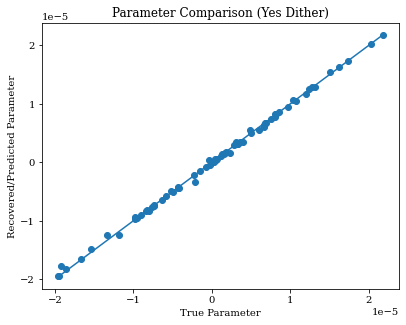

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Convert to NumPy arrays if they're JAX arrays
true_vals = np.array(true_params)
pred_vals = np.array(best_params_list[1])

plt.figure()
plt.scatter(true_vals, pred_vals)

# Add a diagonal line for reference
xmin, xmax = true_vals.min(), true_vals.max()
ref_line = np.array([xmin, xmax])
plt.plot(ref_line, ref_line)

plt.xlabel("True Parameter")
plt.ylabel("Recovered/Predicted Parameter")
plt.title("Parameter Comparison (Yes Dither)")
#plt.savefig("predicted_vs_true_order_7_dither.png")

plt.show()

In [37]:
print("Index |        True Param        |     Predicted Param")
print("------|--------------------------|----------------------")
for i in range(len(true_params)):
    print(f"{i:4d}  |  {float(true_params[i]):+12.6e}  |  {float(best_params_list[7][i]):+12.6e}")

Index |        True Param        |     Predicted Param
------|--------------------------|----------------------
   0  |  +1.622642e-05  |  +1.622674e-05
   1  |  +2.025265e-05  |  +2.025765e-05
   2  |  -4.335944e-06  |  -4.333159e-06
   3  |  -7.861735e-07  |  -8.109250e-07
   4  |  +1.760909e-06  |  +1.774626e-06
   5  |  -9.720892e-06  |  -9.716682e-06
   6  |  -4.952987e-06  |  -5.019901e-06
   7  |  +4.943786e-06  |  +4.899267e-06
   8  |  +6.643493e-06  |  +6.517429e-06
   9  |  -9.501635e-06  |  -9.578001e-06
  10  |  +2.179530e-05  |  +2.190909e-05
  11  |  -1.955151e-05  |  -1.948222e-05
  12  |  +3.585707e-06  |  +3.689243e-06
  13  |  +1.577951e-06  |  +1.431947e-06
  14  |  +1.277085e-05  |  +1.272324e-05
  15  |  +1.510465e-05  |  +1.534478e-05
  16  |  +9.706559e-06  |  +9.880729e-06
  17  |  +5.996080e-06  |  +6.002897e-06
  18  |  +2.470071e-07  |  +2.692072e-07
  19  |  -1.916477e-05  |  -1.860873e-05
  20  |  -1.859349e-05  |  -1.827622e-05
  21  |  +1.728144e-05  |  